# Bitcoin and Twitter: How much does the overall sentiment impact?

# Part 1: Formulation of Dataset (Produces no visible output, is scheduled to run once every few hours)

In [7]:
import tweepy
import numpy as np
import pandas as pd
import re
import time

import nltk
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

import investpy
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing libraries

## Connecting to Twitter API

In [8]:
consumer_key = 'SfoViURKU5bLdRz3bRi2t0vbg'
consumer_secret = '8KpNuLewNZEy4jDNlm7auQat0tV6qnbYCIrc1avlNxGc9AUAg0'
access_token = '1391609532963385344-Sb8dWwiC3Xma3XLyEygEmDFLbFAGtZ'
access_token_secret = 'VAZWTc0XuHxpR94NEXjjEFnf8hEyuvJM3HL5pJuMZQudj'

In [9]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

## Performing Text Cleaning

In [10]:
def TextClean(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'#[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'&[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'[?!.+,;%&"]+', '', tweet)
    tweet = re.sub(r'rt[\s]+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\$', '', tweet)
    tweet = re.sub(r'rt+', '', tweet)
    tweet = re.sub(r'https?:?\/\/\S+', '', tweet)
    tweet = re.sub(r'\n','',tweet)
    
    return tweet

## Performing tweet search

In [11]:
def tweet_search(key_word,limit):
    i = 0
    tweets_df = pd.DataFrame(columns=['DateTime','Tweet','Username','Retweets','Likes','Followers'])
    for tweet in tweepy.Cursor(api.search, q = key_word, count = 50, lang = 'en', tweet_mode = 'extended').items():
        if (tweet.user.followers_count>500):
            tweets_df = tweets_df.append({'DateTime': tweet.created_at, 
                                        'Tweet':tweet.full_text, 
                                        'Username':tweet.user.screen_name, 
                                        'Retweets':tweet.retweet_count, 
                                        'Likes':tweet.favorite_count, 
                                        'Followers':tweet.user.followers_count}, ignore_index = True)
            i+=1
        if i>limit:
            break
        else:
            pass
        
    tweets_df['DateTime'] = pd.to_datetime(tweets_df['DateTime'], format = '%d,%m,%Y %H:%M:%S')
    tweets_df.set_index('DateTime',inplace=True)
    tweets_df['CleanTweet'] = tweets_df['Tweet'].apply(TextClean)
    tweet_tokenizer = TweetTokenizer()
    tweets_df['TokenizedTweet'] = tweets_df['CleanTweet'].apply(tweet_tokenizer.tokenize)
    tweets_df['TokenizedTweet'] = [', '.join(map(str,token)) for token in tweets_df['TokenizedTweet']]
    return tweets_df

In [12]:
while True:
    try:
        df1 = tweet_search('bitcoin',750)
        df2 = tweet_search('btc',750)
        break
    except tweepy.TweepError as e:
        print(e.reason)
        time.sleep(5)
        
df = pd.concat([df1, df2])
df.sort_values('DateTime',inplace=True)
df = df.drop_duplicates(subset = ['CleanTweet'])

## Perform VaderAnalysis and TextBlob

In [13]:
def vader_score(tweet):
    vader = SentimentIntensityAnalyzer()
    if vader.polarity_scores(tweet)['compound'] >= 0.05:
        return 'Positive'
    elif vader.polarity_scores(tweet)['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
def text_blob(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [14]:
df['VaderAnalysis'] = df['TokenizedTweet'].apply(vader_score)
df['TextBlobAnalysis'] = df['TokenizedTweet'].apply(text_blob)
with open('C:/Users/admin/Desktop/Sentiment Analysis/Tweets_Collection.csv', 'a', encoding="utf-8") as f:
    df.to_csv(f, header=f.tell()==0)

In [15]:
start_date = (df.iloc[0].name.date().strftime("%x"))
start_time = df.iloc[0].name.date().strftime("%X")
end_date = (df.iloc[-1].name.date().strftime("%x"))
end_time = df.iloc[-1].name.date().strftime("%X")

## Getting historical data using investpy

In [16]:
#To start the Historical_data.csv file-Get the first value
today = date.today().strftime('%d/%m/%Y')
yesterday = (date.today() - timedelta(days = 1)).strftime('%d/%m/%Y')


#data = investpy.get_crypto_historical_data(crypto='bitcoin',from_date=yesterday,to_date=today)

#data['Change%'] = ((data['Close'] - data['Close'].shift(1))/data['Close'])*100
#print(data.iloc[[1]])
#with open('C:/Users/admin/Desktop/Sentiment Analysis/Historical_data.csv', 'a') as f:
    #data.iloc[[1]].to_csv(f, header=f.tell()==0)


In [17]:
his_data = pd.read_csv('C:/Users/admin/Desktop/Sentiment Analysis/Historical_data.csv')
his_data = his_data.loc[ : , his_data.columns != 'Change%']
data = investpy.get_crypto_historical_data(crypto='bitcoin',from_date=yesterday,to_date=today)
data = data.iloc[[1]]
data['Date']=date.today().strftime('%Y-%m-%d')
hist_data = pd.concat([his_data, data],ignore_index=True)
hist_data['Change%'] = ((hist_data['Close'] - hist_data['Close'].shift(1))/hist_data['Close'])*100
with open('C:/Users/admin/Desktop/Sentiment Analysis/Historical_data.csv', 'a') as f:
    hist_data.iloc[[-1]].to_csv(f, header=f.tell()==0, index=False)

In [18]:
bit_index = pd.read_csv('C:/Users/admin/Desktop/Sentiment Analysis/Historical_data.csv')
bit_index['Date'] = pd.to_datetime(bit_index['Date'])
bit_index_date = bit_index['Date'].iloc[-1].date().strftime("%x")

## Feeding into the finalised dataset

In [19]:
def price_checker(pricing_list=bit_index, tweet_analysis=df, date1=end_date, date2=bit_index_date):
    if date1==date2:
        total_count = len(tweet_analysis)
        vader_positive_count = len(tweet_analysis[tweet_analysis['VaderAnalysis']=='Positive'])
        vader_positive_ratio = round(len(tweet_analysis[tweet_analysis['VaderAnalysis']=='Positive'])/len(tweet_analysis),4)
        vader_negative_count = len(tweet_analysis[tweet_analysis['VaderAnalysis']=='Negative'])
        vader_negative_ratio = round(len(tweet_analysis[tweet_analysis['VaderAnalysis']=='Negative'])/len(tweet_analysis),4)
        textblob_positive_count = len(tweet_analysis[tweet_analysis['TextBlobAnalysis']=='Positive'])
        textblob_positive_ratio = round(len(tweet_analysis[tweet_analysis['TextBlobAnalysis']=='Positive'])/len(tweet_analysis),4)
        textblob_negative_count = len(tweet_analysis[tweet_analysis['TextBlobAnalysis']=='Negative'])
        textblob_negative_ratio = round(len(tweet_analysis[tweet_analysis['TextBlobAnalysis']=='Negative'])/len(tweet_analysis),4)
        
        rate_change = float((pricing_list['Change%'].iloc[-1]))
        return pd.DataFrame({'Change':[rate_change],
                             'Total Count':[total_count],
                             'Positive Count - Vader':[vader_positive_count],
                             'Positive Rate - Vader':[vader_positive_ratio],
                             'Negative Count - Vader':[vader_negative_count],
                             'Negative Ratio - Vader':[vader_negative_ratio],
                             'Positive Count - TextBlob':[textblob_positive_count],
                             'Positive Rate - TextBlob':[textblob_positive_ratio],
                             'Negative Count - TextBlob':[textblob_negative_count],
                             'Negative Ratio - TextBlob':[textblob_negative_ratio]},index=[date1])
    else:
        return 'Price matching not available on seperate dates'

In [20]:
with open('C:/Users/admin/Desktop/Sentiment Analysis/Rate_Checker.csv', 'a') as f:
    price_checker().to_csv(f, header=f.tell()==0)

# Part 2: Analysis of created dataset 

# Part 2.1: Tweet collection visualisation

### Importing Libraries

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import *

from wordcloud import WordCloud

In [22]:
tweets = pd.read_csv('Tweets_collection.csv')
tweets.head()

,DateTime,Tweet,Username,Retweets,Likes,Followers,CleanTweet,TokenizedTweet,VaderAnalysis,TextBlobAnalysis
0,2021-05-19 14:38:09,@scottmelker When you bought $BTC days ago htt...,OmoYOrubani,0,4,2195,when you bought btc days ago,"when, you, bought, btc, days, ago",Neutral,Neutral
1,2021-05-19 14:38:10,"RT @notEezzy: Dear noobs, \r\n $BTC is NOT...",Fcastrox,204,0,570,dear noobs btc is not naturally going dow...,"dear, noobs, btc, is, not, naturally, going, d...",Positive,Negative
2,2021-05-19 14:38:10,RT @Realnaz_: Are we in a bitcoin bear market?...,electralindadgb,1,0,1459,are we in a bitcoin bear market👇👇👇let's see if...,"are, we, in, a, bitcoin, bear, market, 👇, 👇, 👇...",Neutral,Positive
3,2021-05-19 14:38:10,IRS: We will seize digital assets for taxes ow...,wearecryptoarmy,0,0,25851,irs: we will seize digital assets for taxes ow...,"irs, :, we, will, seize, digital, assets, for,...",Positive,Neutral
4,2021-05-19 14:38:10,RT @CptHodl: It was days like these that shook...,quadriinvention,655,0,987,it was days like these that shook out a lot of...,"it, was, days, like, these, that, shook, out, ...",Positive,Positive


In [23]:
def remove_pattern(input_text,pattern):
    r = re.findall(pattern,input_text)
    for i in r:
        input_text = re.sub(i,'',input_text)
    return input_text

tweets['tidy_tweet'] = np.vectorize(remove_pattern)(tweets['Tweet'], "@[\w]*") #To remove @
tweets['tidy_tweet'] = tweets['tidy_tweet'].str.replace("[^a-zA-Z#]"," ") #To remove everything except letters and #
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #To remove short words

tokenized_tweet = tweets['tidy_tweet'].apply(lambda x: x.split())
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

for i in range(len(tokenized_tweet)):     
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])     
tweets['tidy_tweet'] = tokenized_tweet

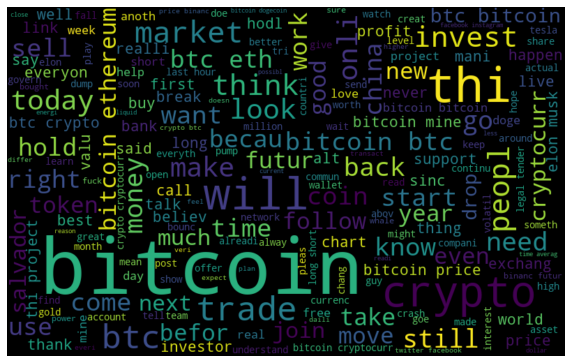

In [24]:
all_words = ' '.join([text for text in tweets['tidy_tweet']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

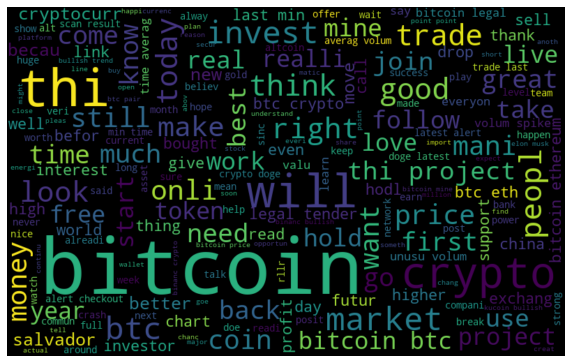

In [25]:
positive_words =' '.join([text for text in tweets['tidy_tweet'][tweets['TextBlobAnalysis'] == 'Positive']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

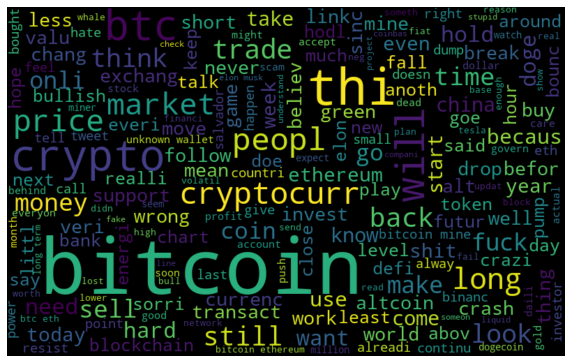

In [26]:
negative_words =' '.join([text for text in tweets['tidy_tweet'][tweets['TextBlobAnalysis'] == 'Negative']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [27]:
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r"#(\w+)",i)
        hashtags.append(ht)
    return hashtags

HT_regular = hashtag_extract(tweets['tidy_tweet'][tweets['TextBlobAnalysis'] == 'Positive']) 
HT_negative = hashtag_extract(tweets['tidy_tweet'][tweets['TextBlobAnalysis'] == 'Negative']) 
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

a = nltk.FreqDist(HT_regular) 
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())}) 

b = nltk.FreqDist(HT_negative) 
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

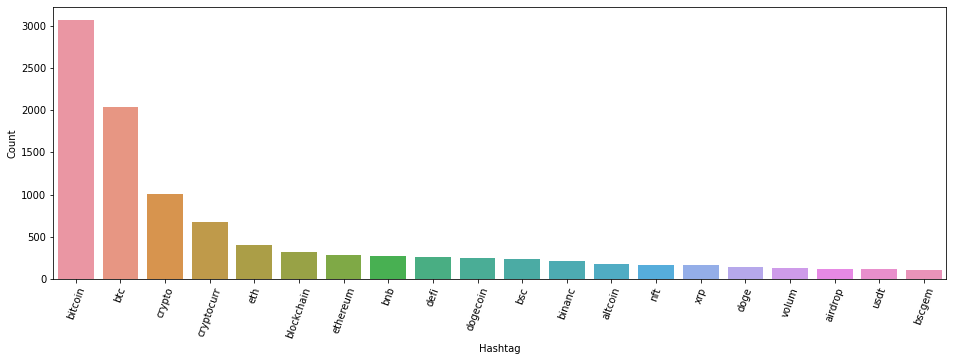

In [28]:
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.tick_params(axis='x',rotation=70)
plt.show()

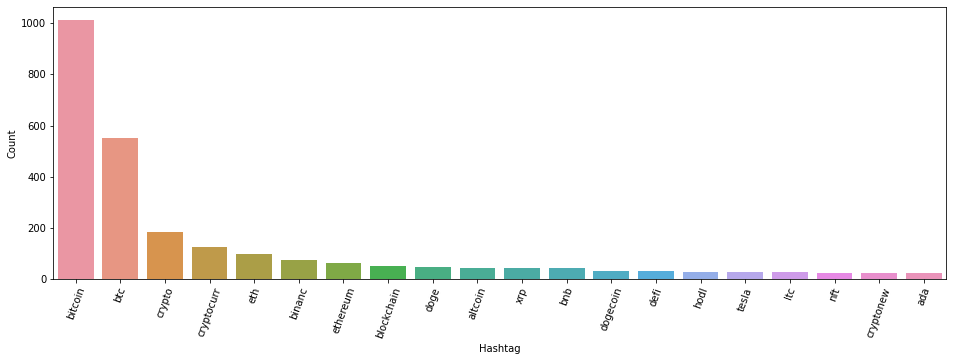

In [29]:
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.tick_params(axis='x',rotation=70)
plt.show()

# Part 2.2: Bitcoin Price fluctuations and tweets (Formulated Dataset)

## Importing Libraries

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

In [31]:
df = pd.read_csv('Rate_Checker.csv')
df.head(10)

,Unnamed: 0,Change,Total Count,Positive Count - Vader,Positive Rate - Vader,Negative Count - Vader,Negative Ratio - Vader,Positive Count - TextBlob,Positive Rate - TextBlob,Negative Count - TextBlob,Negative Ratio - TextBlob
0,05/16/21,0.002248,1086,438,0.4033,209,0.1924,448,0.4125,173,0.1593
1,05/16/21,0.323110,921,406,0.4408,196,0.2128,385,0.4180,150,0.1629
2,05/16/21,-0.740487,1011,465,0.4599,201,0.1988,467,0.4619,144,0.1424
3,05/16/21,-2.963943,1067,427,0.4002,240,0.2249,486,0.4555,166,0.1556
4,05/17/21,-4.823390,1086,422,0.3886,273,0.2514,425,0.3913,202,0.1860
5,05/17/21,-0.507607,670,273,0.4075,139,0.2075,251,0.3746,110,0.1642
6,05/17/21,0.549763,1016,424,0.4173,245,0.2411,428,0.4213,175,0.1722
7,05/17/21,-0.546311,970,418,0.4309,231,0.2381,430,0.4433,169,0.1742
8,05/17/21,-5.146181,1070,430,0.4019,254,0.2374,435,0.4065,187,0.1748
9,05/18/21,5.717716,1059,436,0.4117,212,0.2002,457,0.4315,155,0.1464


In [32]:
for i in range(0,len(df)-2):
    df.loc[i,'Rise'] = np.where(df.loc[i+1, 'Change']>=0,1,0)
    
df = df[0:35]

In [33]:
Y = df['Rise'] # Target 
X = df[['Total Count','Positive Count - Vader','Positive Rate - Vader','Negative Count - Vader','Negative Ratio - Vader','Positive Count - TextBlob','Negative Count - TextBlob','Negative Ratio - TextBlob']] # Inputs

#65:35 Train-Test split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.35, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [34]:
best_score = 0
kfolds = 5

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv = kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

Best accuracy on validation set is: 0.73
Best parameters of M, d, m are:  8 3 4
Test accuracy with the best parameters is 0.3076923076923077
Test recall with the best parameters is: 0.2
Test AUC with the best parameters is: 0.2875


In [35]:
best_score = 0
kfolds = 5 
acc_ol = []

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
                
# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test auc with the best parameter is", test_auc)

Best accuracy on cross validation set is: 0.6900000000000001
Best parameter for c is:  10
Best parameter for gamma is:  0.001
Best parameter for kernel is:  linear
Test accuracy with the best parameters is 0.46153846153846156
Test auc with the best parameter is 0.375
